In [ ]:
#default_exp data_loading

In [ ]:
#export
import torch
from PIL import Image
from pathlib import Path
from fastai.basics import *
from fastai.vision.data import *
from fastai.vision.all import *
from fastai.text.all import *

In [ ]:
path=Path('../danbooru2020')
image_path=path/'512px/'
meta=path/'meta'

In [ ]:
with open('named_tags.pkl','rb') as f: named_tags=pickle.load(f)
with open('id_tags.pkl','rb') as f: id_tags=pickle.load(f)
full_table = pd.read_pickle('fulll_table.pkl')

In [ ]:
#I forget why we do this, but needed to be done for dataloader, might be fastai bug? 
#export
@patch
@delegates(TfmdDL.new)
def new(self:SortedDL, dataset=None, **kwargs):
    res = self.res if dataset is None else None
    
    return super(SortedDL, self).new(dataset=dataset, **merge({'res':res}, kwargs))

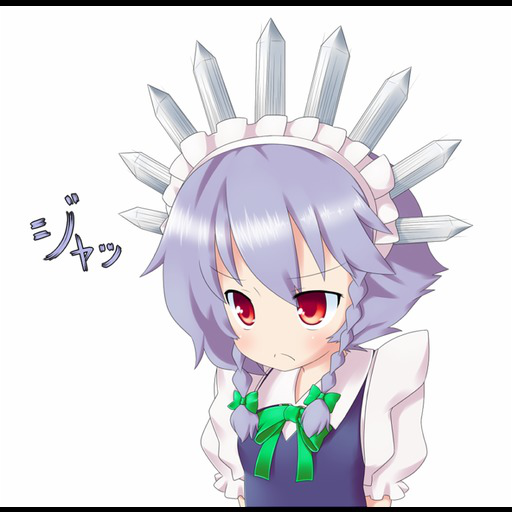

In [ ]:
Image.open(Path('../danbooru2020/512px/0000/400000.jpg'))

In [ ]:
#export
class df_text(Transform):
    def __init__(self,table):
        self.table=table
    def encodes(self,path):
        file_id=int(path.stem)
        tags=L(list(self.table[self.table.id==file_id].tags.item()))
        return [' '.join(tags.shuffle().map(lambda x:id_tags[x]))]
    def decodes(self,text):
        return TitledStr(' '.join(text))

In [ ]:
#export
def get_filtered_image_files(path):
    return get_image_files(path).filter(lambda p:p.stem[-2:]!='_n')

In [ ]:
full_table

,id,image_width,image_height,tags
0,263202,1042,1024,"[1821, 466061, 437490, 16751, 537684, 16867, 1976, 13804, 454933, 446622, 1707, 16613, 13197, 1287928, 566835, 8526, 464575, 15189, 4123, 89189]"
1,3014637,1191,1684,"[1409425, 470575, 475187, 376054, 6539, 87788, 3389, 8601, 466499, 687973, 10960, 658573, 1566, 4311, 469576, 1442807, 9294, 11906, 412368, 212816, 15675, 444]"
2,2872191,756,869,"[470575, 497007, 632214, 380350, 1231860, 1377427, 11813, 469576, 16750, 11429, 389378, 1242303, 1709, 574407, 11154]"
3,2873161,537,562,"[1821, 273, 449529, 579793, 419429, 194013, 452195, 380350, 1231860, 1377427, 469576, 566835, 584749, 383282, 403577, 1387590, 684639, 581144, 1310137, 1242303, 16509, 268819, 15080, 472154, 412368, 429, 12682, 1709]"
4,2872175,868,1228,"[470575, 9114, 1247173, 613194, 513837, 380350, 426491, 1566, 1231860, 1377427, 401601, 1681, 438623, 2355, 16509, 268819, 8672, 412368, 1882, 515193, 10644]"
...,...,...,...,...
3219026,2372253,607,859,"[1821, 384553, 14599, 402217, 566918, 273, 475187, 527167, 1398442, 613194, 87788, 10959, 314230, 8601, 4607, 465619, 4172, 600177, 580394, 1275036, 1307232, 2373, 2750, 464808, 1563139, 524897, 1231860, 403247, 13197, 479563, 566835, 11906, 2363, 448202, 1296381, 1815, 4695, 1578413, 384905, 1882, 10863, 502710, 1709, 1077303, 533054]"
3219027,1767681,900,571,"[470575, 380490, 11826, 2585, 10369, 515769, 396859, 483853, 560167, 15395, 632123, 465525, 71730, 572915, 2060, 427008, 680569, 390662, 6532, 698860, 442865, 1231860, 406241, 1245319, 102962, 490999, 391, 2770, 402239, 464572, 383282, 473775, 8526, 503552, 8565, 12289, 429, 1815, 212816, 1238042, 519572, 2056, 28200, 1337568, 1709, 464906, 16581]"
3219028,1808402,1134,1417,"[470575, 384553, 742715, 1592379, 684986, 520850, 1373029, 10959, 6128, 643561, 6532, 380350, 399541, 2646, 1269433, 2750, 1566, 1231860, 427348, 469576, 1499947, 384774, 11906, 389378, 16509, 1441885, 268819, 15080, 15425, 412368, 1815, 212816, 1441886]"
3219029,1929862,1200,1600,"[470575, 6126, 376054, 87788, 10959, 11904, 682963, 466499, 1269639, 660909, 395321, 1793, 464559, 400123, 380350, 1566, 16613, 1231860, 531403, 13197, 469576, 1315840, 438623, 494251, 11906, 1305447, 389378, 221, 412368, 212816, 444, 133767, 15674, 4232, 2444, 462808, 515193, 385639, 407678]"


In [ ]:
#export
def open_image(path):
    file_id=int(path.stem)
    img=PILImage.create(path)
    width=int(full_table[full_table.id==file_id].image_width.item())
    height=int(full_table[full_table.id==file_id].image_height.item())
    pw, ph = img.size 
    if(width>height): dim=(0,(1-height/width)*256,512,256+height/width*256)
    else: dim=((1-width/height)*256,0,256+width/height*256,512)
    return PILImage(img.crop(dim))

In [ ]:
#export
def MyImageBlock(cls=PILImage):
    "A `TransformBlock` for images of `cls`"
    return TransformBlock(type_tfms=open_image, batch_tfms=IntToFloatTensor)

In [ ]:
#export
class Remove1(Transform):
    def encodes(self,x):
        return next(x)

In [ ]:
#export
def DALLE_dataloader():
    with open('vocab.pkl','rb') as f: vocab=pickle.load(f)
    tok=SentencePieceTokenizer(max_vocab_sz=2500,sp_model=Path('tmp/spm.model'))
    text_block=TextBlock(tok,vocab=vocab)
    text_block.type_tfms.insert(1,Remove1())
    dblock = DataBlock(blocks    = (MyImageBlock,text_block, CategoryBlock),
                   get_items = get_filtered_image_files,
                   get_x     = [lambda x:x,df_text(full_table)],
                   get_y     = lambda x:1,
                   splitter  = RandomSplitter(),
                   n_inp=2,
                   item_tfms = Resize(224)
                  )
    return dblock.dataloaders(image_path, bs=64, seq_len=72,dl_kwargs=[{'res':range(2575225)},{'res':range(643806)},{}])

Warnings below should be fine as long as they only relate to metadata. 

In [ ]:
#with open('vocab' + '.pkl', 'wb') as f: pickle.dump(list(count.keys()), f, pickle.HIGHEST_PROTOCOL)

In [ ]:
dls=DALLE_dataloader()

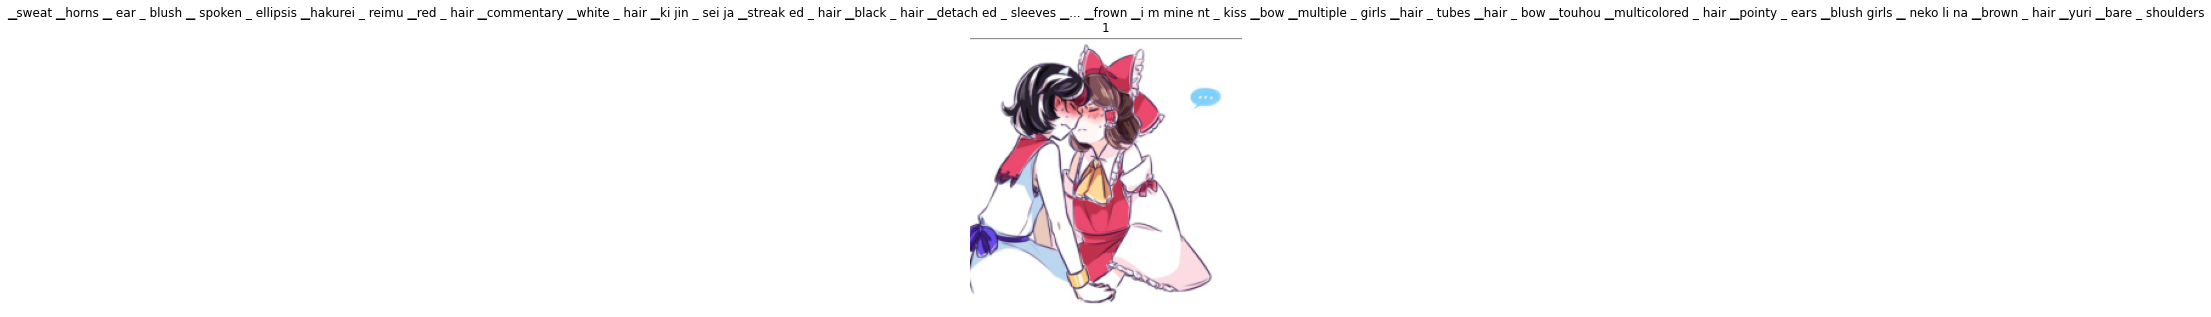

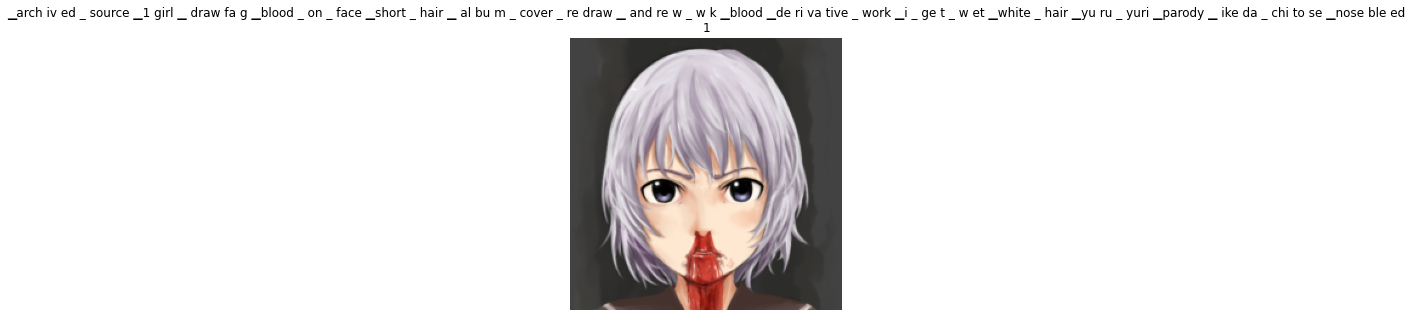

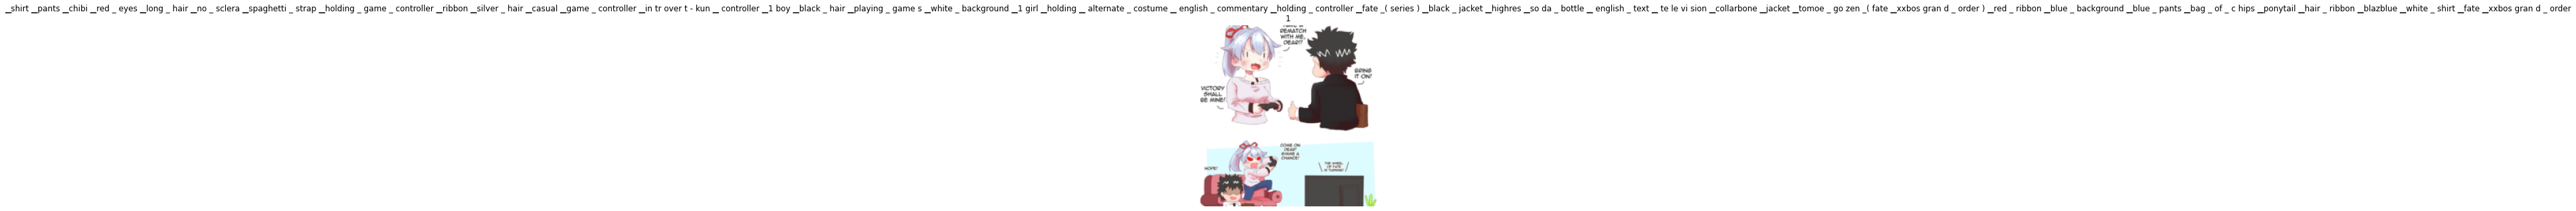

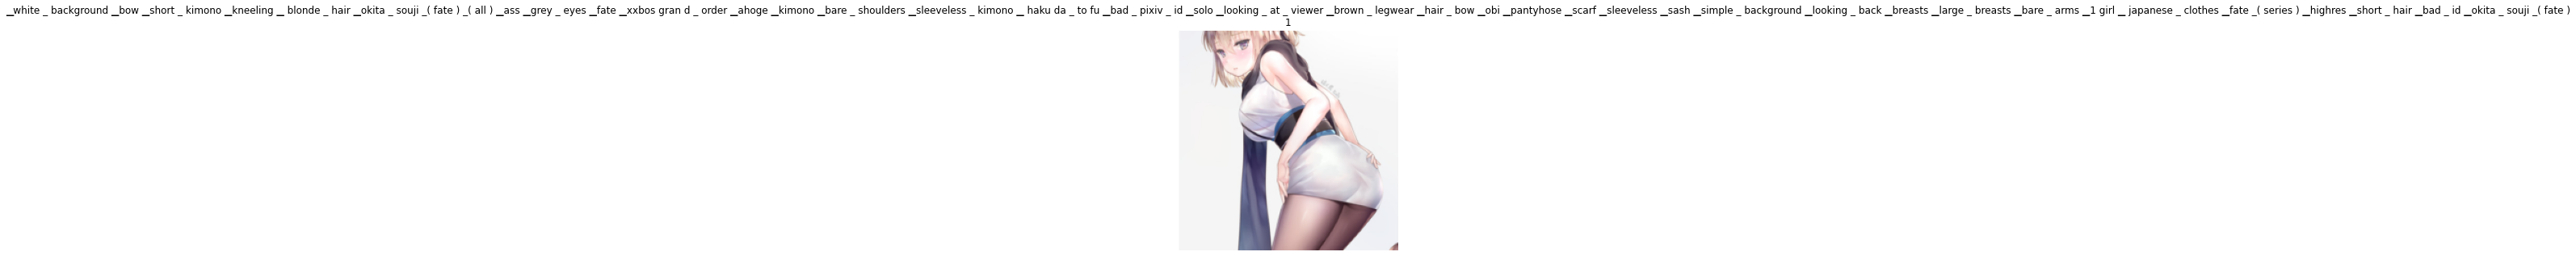

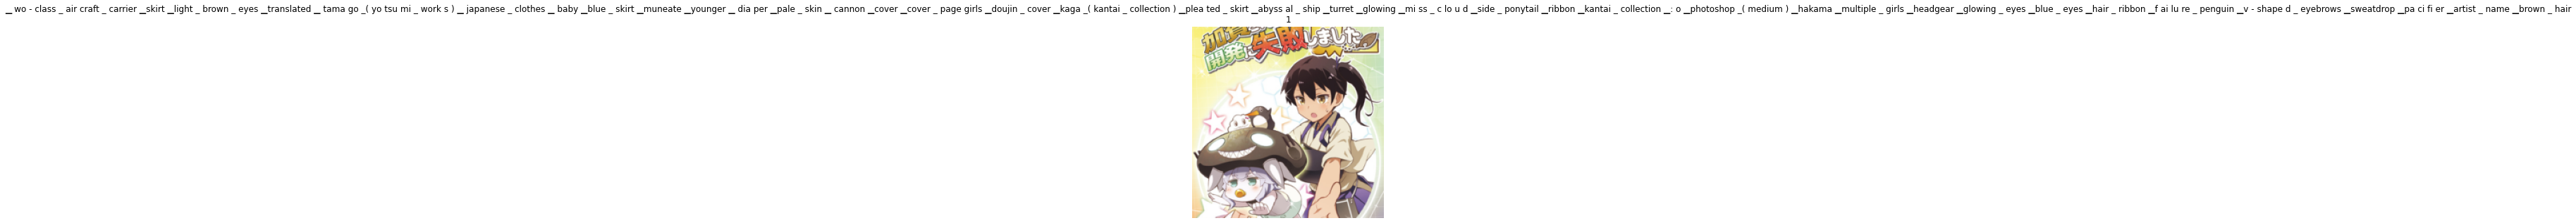

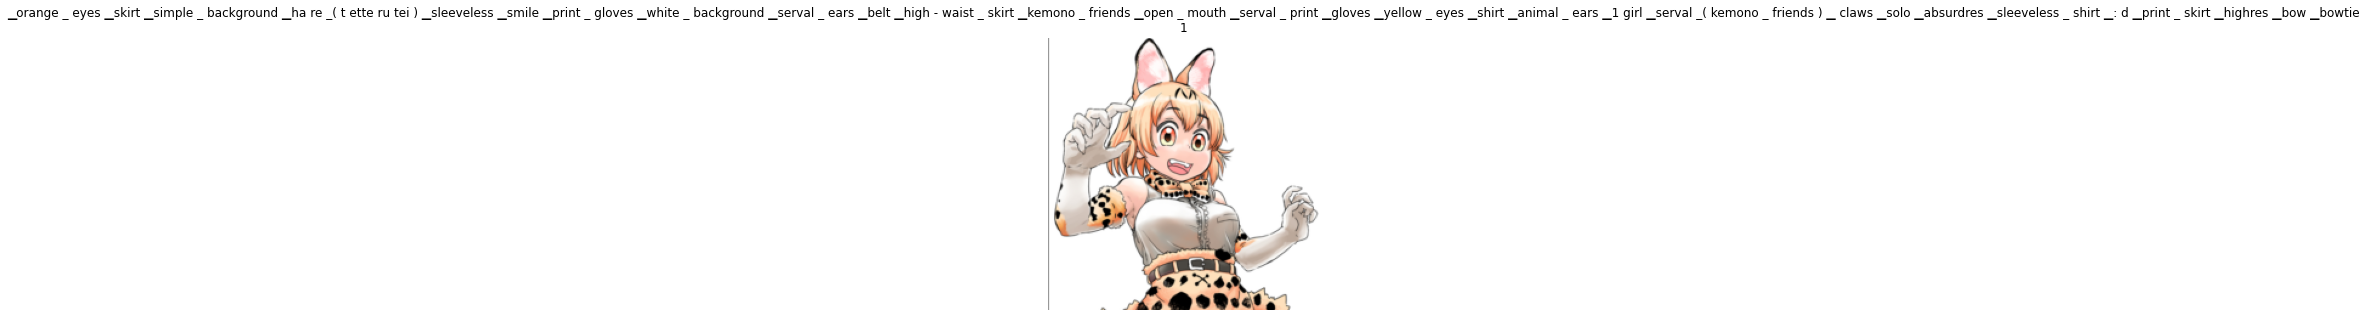

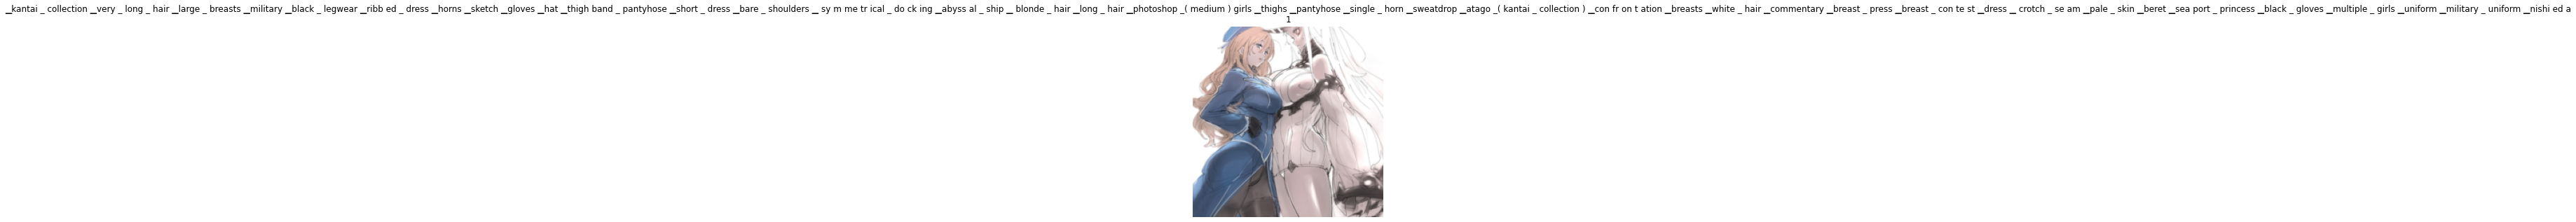

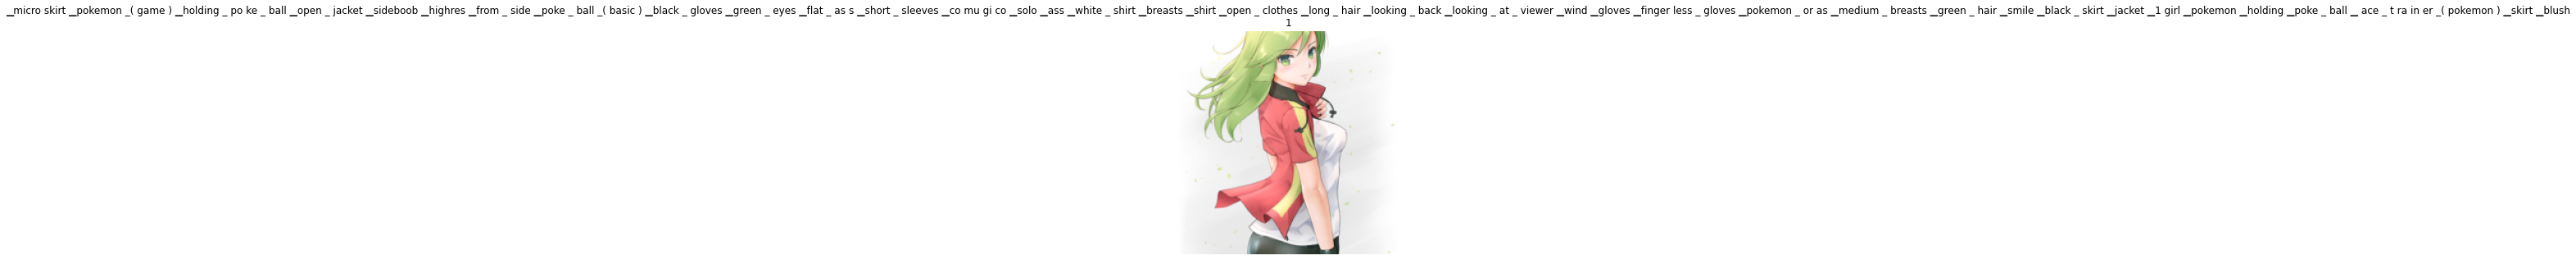

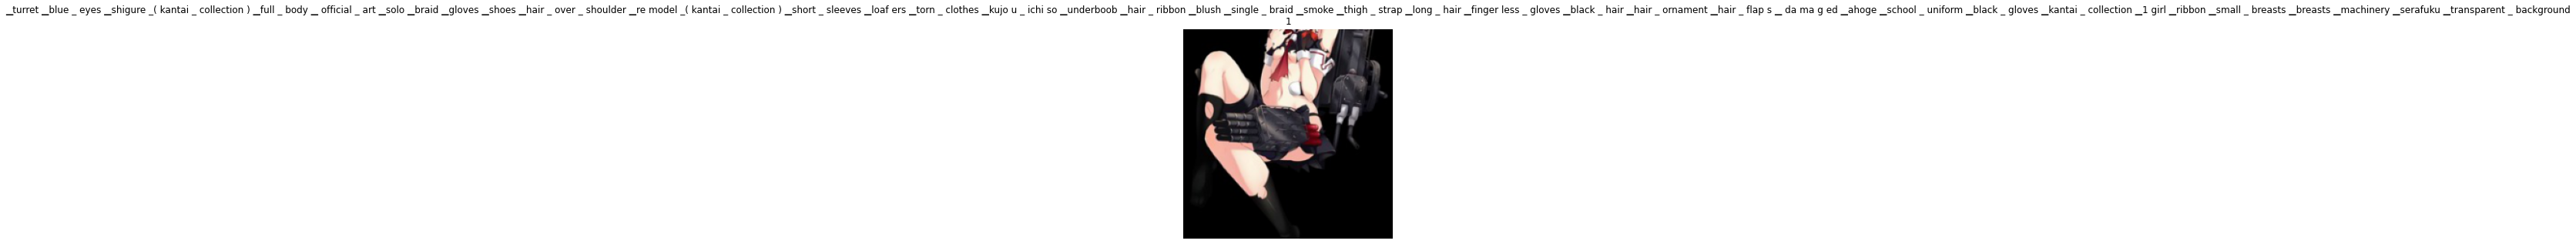

In [ ]:
dls.show_batch()

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted Anki.ipynb.
Converted CLIP.ipynb.
Converted DataLoading.ipynb.
Converted Initial-inspection.ipynb.
Converted Reformer-First-Glance.ipynb.
Converted Reformer.ipynb.
Converted StudyGroup-example.ipynb.
Converted VAE Reference.ipynb.
Converted VAE.ipynb.
Converted aggregate_image_tags.ipynb.
Converted tags2tokens.ipynb.
